<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/5_8_extract_features_from_scene_imags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this tutorial, we extract features from scene images using DNN models as presented in these studies:

1. [Kaiser et al., 2020](https://www.sciencedirect.com/science/article/pii/S1053811920305310) <-- I still think they credited the wrong paper, "...Stimuli were 210 natural scene photographs, taken from an online resource (Konkle et al., 2010). ..."
2. [Konkle, Brady, Alvarez, & Oliva, 2012, Psychological Science](http://olivalab.mit.edu/MM/downloads/Scenes.zip)

In [55]:
import os
if not os.path.exists('scenes/'):
    !wget http://olivalab.mit.edu/MM/downloads/Scenes.zip
    !unzip Scenes.zip -d scenes/
    !rm scenes/68-scenes/field-68/._mountain_14_13_yahoo.jpg

In [56]:
if not os.path.exists('moco_v2_800ep_pretrain.pth.tar'):
    !wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar

# First, we extract features from ResNet50 that was pre-trained with the ImageNet dataset.

In [57]:
import os,torch
from torch.utils import data
from torchvision import transforms,datasets,models as torch_models

import numpy as np
import pandas as pd

from tqdm import tqdm

In [58]:
main_folder = 'scenes/'
torch.manual_seed(12345)
if torch.cuda.is_available():torch.cuda.empty_cache();torch.cuda.manual_seed(12345);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## some helper functions

In [59]:
def simple_augmentations(image_resize   = 128,
                         rotation       = True,
                         gitter_color   = False,
                         ):
    """
    Simple augmentation steps
    
    Inputs 
    ---
    image_resize: int, the height and width of the images
    rotation: bool, one of the augmentation methods, for object recognition only
    gitter_color: bool, one of the augmentation methods, for Gabor only
    
    Outputs
    ---
    torchvision.transformer object
    """
    steps = [transforms.Resize((image_resize,image_resize)),]
    
    if rotation and not gitter_color:
        steps.append(transforms.RandomHorizontalFlip(p = 0.5))
        steps.append(transforms.RandomRotation(45,))
        steps.append(transforms.RandomVerticalFlip(p = 0.5))
    elif gitter_color and not rotation:
        steps.append(transforms.RandomCrop((image_resize,image_resize)))
        steps.append(transforms.ColorJitter(brightness = 0.25,
                                            contrast = 0.25,
                                            saturation = 0.25,
                                            hue = 0.25,))
    
    steps.append(transforms.ToTensor())
    steps.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    
    transform_steps = transforms.Compose(steps)
    return transform_steps

class customizedDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        original_tuple  = super(customizedDataset,self).__getitem__(idx)
        path = self.imgs[idx][0]
        tuple_with_path = (original_tuple +  (path,))
        return tuple_with_path

def data_loader(data_root:str,
                augmentations:transforms    = None,
                batch_size:int              = 8,
                num_workers:int             = 2,
                shuffle:bool                = True,
                ):
    """
    data loader function to create the iterator

    Inputs
    ---
    data_root: string,
    augmentation: transformers
    batch_size: int
    num_worders: int, # of CPUs
    shuffle: bool

    Outputs
    ---
    dataloader: dataloader
    """
    dataset_obj = customizedDataset(
                root                        = data_root,
                transform                   = augmentations
                )
    loader      = data.DataLoader(
                dataset_obj,
                batch_size                  = batch_size,
                num_workers                 = num_workers,
                shuffle                     = shuffle,
                )
    return loader

## Define a data loader

In [60]:
dataloader = data_loader(
                        data_root = main_folder,
                        augmentations = simple_augmentations(image_resize = 128,
                                                             rotation = False,
                                                             gitter_color = False,
                                                             ),
                        batch_size = 32,
                        num_workers = 2,
                        shuffle = False,
                        )

## Load the Resnet50 trained with the ImageNet dataset

In [61]:
resnet50 = torch_models.resnet50(pretrained = True,progress = False).to(device)
resnet_feature_extractor  = torch.nn.Sequential(*list(resnet50.children())[:-2])

## extract the features. 

Please note the the output of the last convolutional layer of the Resnet50 was (2048, 7,7), so we need a global average/max pooling layer to average those last two dimensions.

In [62]:
iterator = tqdm(dataloader)
with torch.no_grad(): # this is important to control RAM use
    paths,features = [],[]
    for image_tensor,image_label,image_path in iterator:
        raw_feature = resnet_feature_extractor(image_tensor.to(device))
        pooled_feature = torch.nn.AdaptiveAvgPool2d((1,1))(raw_feature)
        extracted_feature = torch.squeeze(torch.squeeze(pooled_feature,3),2)
        paths.append(image_path)
        features.append(extracted_feature)
        #iterator.set_description(f'{image_path}')


100%|██████████| 149/149 [00:16<00:00,  8.93it/s]


In [63]:
temp = []
for row in paths:
    for item in row:
        temp.append(item)
paths = np.array(temp)

## Put the tensors back to cpu memory and convert them to numpy arrays

In [64]:
features = torch.cat(features).detach().cpu().numpy()

## Save the data to a dataframe

In [65]:
df = dict(sub_folder = [],
          category = [],
          )
for ii in range(features.shape[1]):df[f'feature{ii}'] = []

In [66]:
for path,feature in tqdm(zip(paths,features)):
    _,sub_folder,category,_ = path.split("/")
    df['sub_folder'].append(sub_folder)
    df['category'].append(category)
    for ii,item in enumerate(feature.flatten()):
        df[f'feature{ii}'].append(item)
df_imagenet = pd.DataFrame(df)

4744it [00:07, 675.90it/s]


# Next, we load the weights from [MOCO-v2](https://github.com/facebookresearch/moco)

### This is from [https://github.com/facebookresearch/moco#see-also](https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb)

In [67]:
from torch import nn
from functools import partial
from torchvision.models import resnet
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss

# create model
model = ModelMoCo(
            arch='resnet50',
            ).to(device)

### This is from https://github.com/facebookresearch/moco/blob/main/main_lincls.py#L161-L172

In [68]:
# rename moco pre-trained keys
state_dict = torch.load('moco_v2_800ep_pretrain.pth.tar',map_location = device)
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        # remove prefix
        state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model.load_state_dict(state_dict, strict=False)

## We build a feature extractor

Please note that the global average/max pooling is included in the pretrained model, so that we don't have to add another one.

In [69]:
resnet_feature_extractor  = torch.nn.Sequential(*list(list(model.encoder_q.children())[0].children())[:-2])
resnet_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): SplitBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): SplitBatchNorm(256, eps=1e-05, momentum=0.1, affine=True,

## extract the features

In [70]:
iterator = tqdm(dataloader)
with torch.no_grad(): # this is important to control RAM use
    paths,features = [],[]
    for image_tensor,image_label,image_path in iterator:
        raw_feature = resnet_feature_extractor(image_tensor.to(device))
        extracted_feature = torch.squeeze(torch.squeeze(raw_feature,3),2)
        paths.append(image_path)
        features.append(extracted_feature)
        #iterator.set_description(f'{image_path}')


100%|██████████| 149/149 [02:52<00:00,  1.16s/it]


In [71]:
temp = []
for row in paths:
    for item in row:
        temp.append(item)
paths = np.array(temp)
features = torch.cat(features).detach().cpu().numpy()

## Save the data to a dataframe

In [72]:
df = dict(sub_folder = [],
          category = [],
          )
for ii in range(features.shape[1]):df[f'feature{ii}'] = []
for path,feature in tqdm(zip(paths,features)):
    _,sub_folder,category,_ = path.split("/")
    df['sub_folder'].append(sub_folder)
    df['category'].append(category)
    for ii,item in enumerate(feature.flatten()):
        df[f'feature{ii}'].append(item)
df_moco = pd.DataFrame(df)

4744it [00:07, 658.00it/s]


# Download dataframe from colab to your local machine

In [73]:
df_imagenet.to_csv('feature_imagenet.csv',index = False)
df_moco.to_csv('feature_moco.csv',index = False)

# Now got to the fifth icon on the left verticle bar, and you will see these two files, and you can download them.

# Some visualizations

In [74]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance

sns.set_style('white')
sns.set_context('poster')

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


Text(0.5, 0.98, 'Features from ResNet trained with Imagenet')

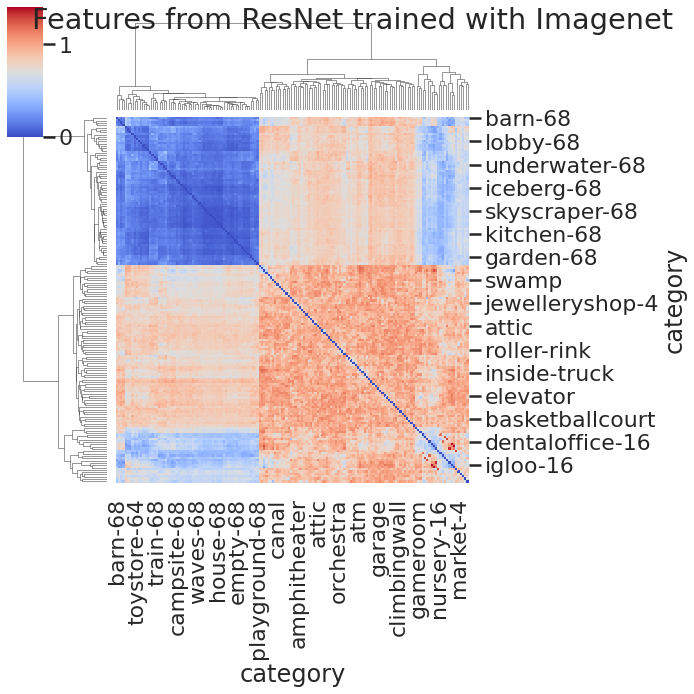

In [75]:
features = df_imagenet.iloc[:,2:].values
df_data = df_imagenet.iloc[:,:2]
features_average = np.array([np.mean(features[df_sub.index],0) for _,df_sub in df_data.groupby(['category'])])
df_average = pd.concat([df_sub.iloc[0].to_frame().T for ii,df_sub in df_data.groupby(['category'])])
rdm = distance.squareform(distance.pdist(features_average,'correlation'))
df_rdm = pd.DataFrame(rdm,columns = df_average['category'],index = df_average['category'])
g = sns.clustermap(df_rdm,figsize = (10,10),cmap = plt.cm.coolwarm,)
g.figure.suptitle('Features from ResNet trained with Imagenet')

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


Text(0.5, 0.98, 'Features from ResNet trained with MOCO method')

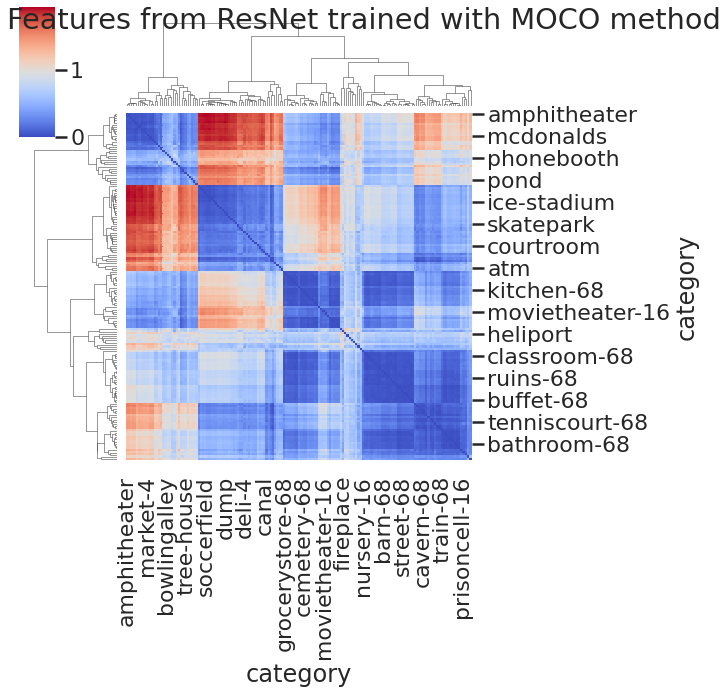

In [76]:
features = df_moco.iloc[:,2:].values
df_data = df_moco.iloc[:,:2]
features_average = np.array([np.mean(features[df_sub.index],0) for _,df_sub in df_data.groupby(['category'])])
df_average = pd.concat([df_sub.iloc[0].to_frame().T for ii,df_sub in df_data.groupby(['category'])])
rdm = distance.squareform(distance.pdist(features_average,'correlation'))
df_rdm = pd.DataFrame(rdm,columns = df_average['category'],index = df_average['category'])
g = sns.clustermap(df_rdm,figsize = (10,10),cmap = plt.cm.coolwarm,)
g.figure.suptitle('Features from ResNet trained with MOCO method')